# About

This notebook uses canopy height data for the state of California obtained through the California Forest Observatory (CFO) API to create a canopy height raster layer for Santa Barbara County. See more about CFO's API here:
https://github.com/forestobservatory/cfo-api

**NOTEBOOK VARIABLES**: 
- year *y* from which we will be accessing the CFO California canopy height raster. *y* must be 2016, 2018 or 2020, since CFO's canopy height data is only available for these years.
- file path to which the Santa Barbara County subset of the canopy height data will be saved. 

**OUTPUT**:
-  canopy height raster layer for Santa Barbara County in the year *y*



To use the notebook you will need to create CFO account. 

An alternative way of doing this could be to follow the 'Custom Data Clipping' section in this tutorial. 
https://github.com/forestobservatory/cfo-api/blob/master/demos/api-introduction.ipynb
To import gdal to the notebook add `from osgeo import gdal`. 

# Install California Forest Observatory API package if not available

In [1]:
#pip install cfo

In [2]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as riox
from shapely.geometry import box

import json
import rasterio
from rasterio.mask import mask

import matplotlib.pyplot as plt

import cfo



# Specify year and file path for canopy height data

In [3]:
# ***************************************************
# ************* NOTEBOOK VARIABLES ******************

# year shuold be 2016, 2018 or 2020
year = 2020

# file path where raster will be saved
fp = os.path.join(os.getcwd(),
                  'SantaBarbaraCounty_lidar',
                  'SantaBarbaraCounty_lidar_'+str(year)+'.tif')

# Create directories
sb_lidar = os.path.join(os.getcwd(), 
                  'SantaBarbaraCounty_lidar')

if not os.path.exists(sb_lidar):
    os.makedirs(sb_lidar)

# ***************************************************
# ***************************************************

# Authenticate 

In [4]:
forest_api = cfo.api()
forest_api.authenticate()

CFO E-mail:  brun@nceas.ucsb.edu
CFO Password:  ············


200

# Download and open CA canopy height raster

In [5]:
# find item id
ca_canopy_itemid = forest_api.search(geography='California', metric='CanopyHeight', year=year)[0]

# filepath to temporary folder
ca_canopy_fp = os.path.join(os.getcwd(), 
                            'temp',
                            'ca_canopyheight_'+str(year)+'.tif')

In [6]:
# download (takes a couple of minutes)
forest_api.download(ca_canopy_itemid, ca_canopy_fp)

# open raster reader
ca_canopy = rasterio.open(ca_canopy_fp)

# Get bounding box for Santa Barbara County mainland

In [7]:
# path to SB county shapefile
sb_fp = '/home/jovyan/msai4earth-esa/shapefiles_n_rasters/SB_geometry/SB_only.shp'

# read as GeoDataFrame
sb = gpd.read_file(sb_fp)

# match CRS with ca_canopy raster
sb = sb.to_crs(ca_canopy.crs)

In [8]:
# we will only use the mainland for the analysis
sb_mainland_bounds = sb.bounds.iloc[0]

bbox = box(sb_mainland_bounds.minx,
           sb_mainland_bounds.miny,
           sb_mainland_bounds.maxx,
           sb_mainland_bounds.maxy)

bbox_df = gpd.GeoDataFrame({'geometry':bbox}, index=[0], crs = sb.crs)
bbox_df

,geometry
0,"POLYGON ((827087.109 3809115.024, 827087.109 3..."


In [9]:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [10]:
coords = getFeatures(bbox_df)
coords

[{'type': 'Polygon',
  'coordinates': [[[827087.108958743, 3809115.024363572],
    [827087.108958743, 3889656.2901281836],
    [712735.1549834597, 3889656.2901281836],
    [712735.1549834597, 3809115.024363572],
    [827087.108958743, 3809115.024363572]]]}]

# Mask CA canopy height raster with Santa Barbara county's bounding box

In [11]:
out_img, out_transform = mask(dataset=ca_canopy, shapes=coords, crop=True)

In [12]:
out_img

array([[[-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        ...,
        [-9999, -9999, -9999, ...,     1,     0,     1],
        [-9999, -9999, -9999, ...,     2,     1,     1],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]]], dtype=int16)

In [13]:
out_img = out_img.squeeze()
out_img.shape

(8055, 11436)

# Save Santa Barbara County canopy height raster

In [14]:
with rasterio.open(
        fp,  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = out_img.shape[0], 
        width = out_img.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = 'int16',
        crs = sb.crs,
        transform = out_transform,
) as dst:
    dst.write(out_img, 1)

# Delete CA canopy height raster

In [15]:
os.remove(ca_canopy_fp)

# Open SB canopy height raster to check shape

In [16]:
clip = rasterio.open(fp).read([1]).squeeze()
clip

array([[-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0],
       [-9999, -9999, -9999, ...,     0,     0,     0],
       ...,
       [-9999, -9999, -9999, ...,     1,     0,     1],
       [-9999, -9999, -9999, ...,     2,     1,     1],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

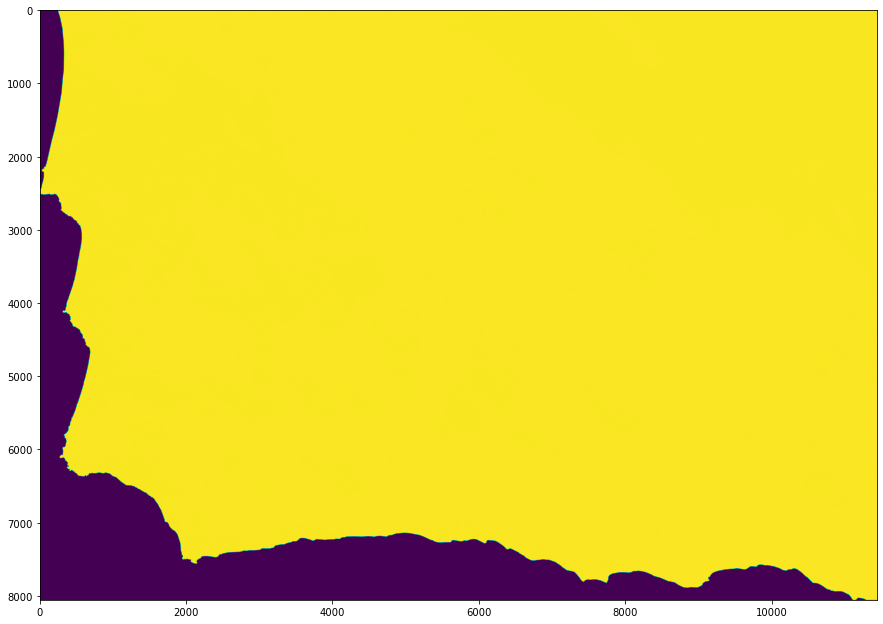

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(clip)
plt.show()